In [13]:
import qso_fit as qso_fit
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM, z_at_value

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = "custom"
plt.rcParams["mathtext.rm"] =  "Times New Roman"
plt.rcParams["mathtext.it"] =  "Times New Roman"
plt.rcParams["mathtext.bf"] =  "Times New Roman"
plt.rcParams.update({'font.size': 14})

NSA_PATH = "nsa_v1_0_1.fits"

## Mock Light Curve Generator

Generate a mock damped random walk (DRW) light curve, adapted from ```astroML.time_series.generate_damped_drw1```.

In [51]:
def mock_drw(t_rest, tau=300., z=2.0, xmean=0, SFinf=0.3):
    
    N = len(t_rest)
    
    t_obs = t_rest * (1. + z) / tau

    x = np.zeros(N)
    x[0] = np.random.normal(xmean, SFinf)
    E = np.random.normal(0, 1, N)

    for i in range(1, N):
        dt = t_obs[i] - t_obs[i - 1]
        x[i] = (x[i - 1]
                - dt * (x[i - 1] - xmean)
                + np.sqrt(2) * SFinf * E[i] * np.sqrt(dt))

    return x

## Define Cadence

Generate an array of times (days) given a number of seasons, epochs per season, and typical seperation per epoch in days. Defaults to DES.

In [286]:
def t_cadence(seasons=5,epochs_per_season=3,sep_per_epoch=1):
    t_days = range(365*seasons)
    t_cadence = []
    for s in range(seasons):
        t_cadence.append(t_days[365*s:epochs_per_season+365*s:sep_per_epoch])
    return np.array(t_cadence).flatten()

## Generate Ensemle of Light Curves

Generate ensemble of DRW light curves given a certain survey cadence and fit light curves using ```qso_fit``` code.

We assume AGNs are "ideal", that is have the exact statistics ```qso_fit``` is looking for. How does the structure function depend on stellar mass?

In [329]:
def ensemble(t_cadence,mag_lim=25,num_objects=10000,distribution="nsa",frac_agn=.1,error_level=0.002):
    
    a1 = -4.10; a2 = 0.14; a3 = 2.92; a4 = -0.07 # g-band structure function parameters
    qso = []; var = []; not_qso = []; mags = [] # initialize output arrays

    print("Generating universe from %s-like distribution." % distribution)
    
    # Which distribution of galaxies to use
    if distribution.lower() == "toy":
        # toy universe
        absolute_mags = np.random.normal(-19.8,1.34,num_objects)
        d = np.random.uniform(0,8500,num_objects)*u.Mpc
        redshifts = [z_at_value(cosmo.comoving_distance,d_i) for d_i in d] 
        # convert to apparent magnitudes
        apparent_mags = absolute_mags + 5*np.log10(d.to(u.pc)/u.pc) - 5
    elif distribution.lower() == "nsa":
        # Nasa Sloan Atlas (NSA) of galaxies
        nsa_fits = fits.open(NSA_PATH)
        obj_nsa = nsa_fits[1].data
        redshifts = obj_nsa["Z"]
        fs = np.array([f[3] for f in obj_nsa["PETRO_FLUX"]]) #  SDSS-style Petrosian flux
        where_pos = fs > 0
        fs = fs[where_pos]
        redshifts = redshifts[where_pos]
        # convert to apparent magnitudes (nanomaggies to mag)
        apparent_mags = [22.5 - 2.5*np.log10(f) for f in fs]
        # shuffle
        np.random.shuffle(np.array(apparent_mags))
        np.random.shuffle(np.array(redshifts))
        # clip size
        num_nsa = len(redshifts)
        if num_objects > num_nsa:
            print("Warning: Clipping number of objects to %d." % num_nsa)
            num_objects = num_nsa
        else:
            apparent_mags = np.random.choice(apparent_mags,num_objects)
            redshifts = np.random.choice(redshifts,num_objects)
    elif distribution.lower() == "cosmos":
        # COSMOS Database
        pass
    
    plt.hist(apparent_mags,bins=range(15,28,1));
    print("Generating ensemble light curves of %d objects." % num_objects)
        
    # Generate ensemble of objects
    for i in range(num_objects):
        m = apparent_mags[i]
        # AGN
        if i < frac_agn*num_objects:
            z = redshifts[i]
            # Definitions from Butler and Bloom (2011)
            sigma_hat = np.sqrt(10**(a1+a2*(m-19)))
            tau = 10**(a3+a4*(m-19))
            SFinf = sigma_hat*tau**0.5
            # Generate mock damped random walk light curve
            mag = mock_drw(t_rest=t_cadence,tau=tau,z=z,xmean=m,SFinf=SFinf)
        # non-AGN
        else:
            mag = np.random.normal(m,error_level*m,len(t_cadence))
        mag_err = error_level*mag
        # Fit mock light curve using qso_fit
        fit = qso_fit.qso_fit(t_cadence,mag,mag_err,filter='g',sys_err=0,return_model=0)
        qso.append(fit["signif_qso"])
        var.append(fit["signif_vary"])
        not_qso.append(fit["signif_not_qso"])
        mags.append(m)
        
    # Truth array
    agn = np.full(num_objects,False)
    agn[:int(frac_agn*num_objects)] = True
            
    return np.array(qso), np.array(var), np.array(not_qso), np.array(mags), np.array(agn)

## Analyze Survey

Generate the cadence, ensemble light curves, and plot variability metrics.

Generating universe from nsa-like distribution.


/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


Generating ensemble light curves of 10000 objects.


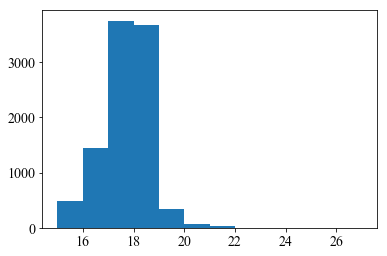

In [330]:
t_cad=t_cadence()
qso, var, not_qso, mags, agn = ensemble(t_cad)

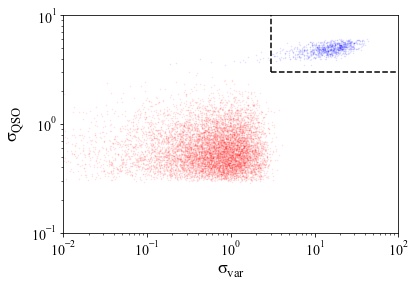

In [347]:
# Plot variability metrics
plt.scatter(var[agn==True],qso[agn==True],alpha=0.1,color="blue",s=.3);
plt.scatter(var[agn==False],qso[agn==False],alpha=0.1,color="red",s=.3);
plt.hlines(3,3,10**4,linestyle="dashed")
plt.vlines(3,3,10**4,linestyle="dashed")
ax=plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(10**-1,10**1)
ax.set_xlim(10**-2,10**2)
plt.ylabel("$\sigma_{QSO}$",fontsize=18);
plt.xlabel("$\sigma_{var}$",fontsize=18);

[0.102880658436214, 0.08668515950069348, 0.10013351134846461, 0.09849931787175989, 0.11143695014662756, 0.08955223880597014, 0.1794871794871795, 0.0, 0.0]


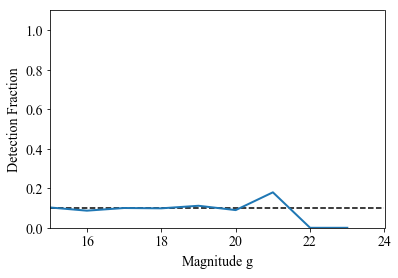

In [340]:
prob = []
hist, bin_edges = np.histogram(mags,bins=range(15,25))
for i in range(len(bin_edges)-1):
    mag_low = bin_edges[i]
    mag_high = bin_edges[i+1]
    ind = np.argwhere((mags>mag_low) & (mags<mag_high))
    if len(ind) == 0:
        print("none")
        continue
    count = 0
    for i in ind:
        if qso[i] > 3 and var[i] > 3:
            count += 1
    prob.append(count/len(ind))
print(prob)
plt.hlines(0.1,15,24,linestyles="dashed");
plt.plot(bin_edges[:-1],prob,linewidth=2);
plt.xlabel("Magnitude $g$");
plt.ylabel("Detection Fraction");
plt.ylim(0,1.1);
plt.xlim(15,24,);